In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy

# how to change this from fooof (1.x.x) to specparam (2.0.0)
from fooof import FOOOFGroup
from fooof.sim.gen import gen_aperiodic

from model import create_model
from scipy.stats import linregress
from scipy.signal import decimate

/var/folders/p7/5y4rzfc927v9625g5xrx460crwqrl3/T/ipykernel_48242/1872962086.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup
--No graphics will be displayed.


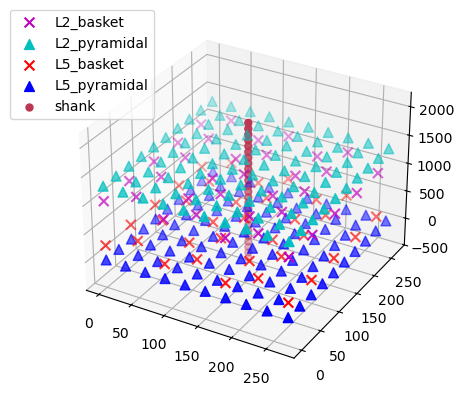

In [2]:
n_trials = 100
n_electrodes = 25

# @Carolina, how to change the colors and shapes of the neurons and electrodes?
net_ds = create_model()
_ = net_ds.plot_cells()

In [3]:
# load and downsample model LFPs
srate_orig = 40000
srate = 2000
dwnsmpl_fctr = int(srate_orig / srate)
ds_trial_signals = np.load('shank_ds.npy')
ds_trial_signals = decimate(ds_trial_signals, dwnsmpl_fctr, n=None, ftype='fir', axis=-1)

In [4]:
winsize = 128
overlap = int(winsize*7/8)
fft_length = int(winsize*16)
freq_lims = [0.5, 250]

**Compute power spectra over whole trial**

In [5]:
# Compute power spectral density from STFT - detected stimuli
freqs, times, Zxx = scipy.signal.stft(ds_trial_signals, fs=srate, window='hann', nperseg=winsize,
                                      noverlap=overlap, nfft=fft_length, detrend='constant',
                                      return_onesided=True, boundary='zeros', padded=True, axis=-1)
print(np.shape(Zxx))
print(freqs)
print(times)

(100, 25, 1025, 58)
[0.00000000e+00 9.76562500e-01 1.95312500e+00 ... 9.98046875e+02
 9.99023438e+02 1.00000000e+03]
[0.    0.008 0.016 0.024 0.032 0.04  0.048 0.056 0.064 0.072 0.08  0.088
 0.096 0.104 0.112 0.12  0.128 0.136 0.144 0.152 0.16  0.168 0.176 0.184
 0.192 0.2   0.208 0.216 0.224 0.232 0.24  0.248 0.256 0.264 0.272 0.28
 0.288 0.296 0.304 0.312 0.32  0.328 0.336 0.344 0.352 0.36  0.368 0.376
 0.384 0.392 0.4   0.408 0.416 0.424 0.432 0.44  0.448 0.456]


In [6]:
ds_layer_psd = np.abs(Zxx) ** 2

f_idx = (freqs>=freq_lims[0]) & (freqs<freq_lims[1])
freqs = freqs[f_idx]

ds_layer_psd_before = ds_layer_psd[:, :, f_idx, times<=0.128]
ds_layer_psd_after = ds_layer_psd[:, :, f_idx, times>=0.128]

# compute means
mds_layer_psd_before = np.mean(ds_layer_psd_before, axis=-1)
mds_layer_psd_after = np.mean(ds_layer_psd_after, axis=-1)

(100, 25, 1025, 58)


**Parameterize power spectra**

In [18]:
# Parameterize detected spectra
ds_layer_offsets = np.zeros((n_trials, n_electrodes))
ds_layer_slopes = np.zeros((n_trials, n_electrodes))
ds_layer_aperiodic = np.zeros((n_trials, n_electrodes, len(freqs)))
for t in range(mds_layer_psd.shape[0]):
    trial_psd = mds_layer_psd[t, :, :]
    
    fg = FOOOFGroup()
    fg.fit(freqs,trial_psd, freq_lims)
    for i in range(trial_psd.shape[0]):
        ds_layer_offsets[t, i] = fg[i].aperiodic_params[0]
        ds_layer_slopes[t, i] = fg[i].aperiodic_params[1]
        ds_layer_aperiodic[t, i, :] = gen_aperiodic(freqs, fg[i].aperiodic_params)

# Parameterize undetected spectra
us_layer_offsets = np.zeros((n_trials, n_electrodes))
us_layer_slopes = np.zeros((n_trials, n_electrodes))
us_layer_aperiodic = np.zeros((n_trials, n_electrodes,len(freqs)))
for t in range(mus_layer_psd.shape[0]):
    trial_psd = mus_layer_psd[t, :, :]
    
    fg = FOOOFGroup()
    fg.fit(freqs, trial_psd, freq_lims)
    for i in range(trial_psd.shape[0]):
        us_layer_offsets[t, i] = fg[i].aperiodic_params[0]
        us_layer_slopes[t, i] = fg[i].aperiodic_params[1]
        us_layer_aperiodic[t, i, :] = gen_aperiodic(freqs, fg[i].aperiodic_params)

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.49
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.49
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.49
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

**Plot spectra and parameters**

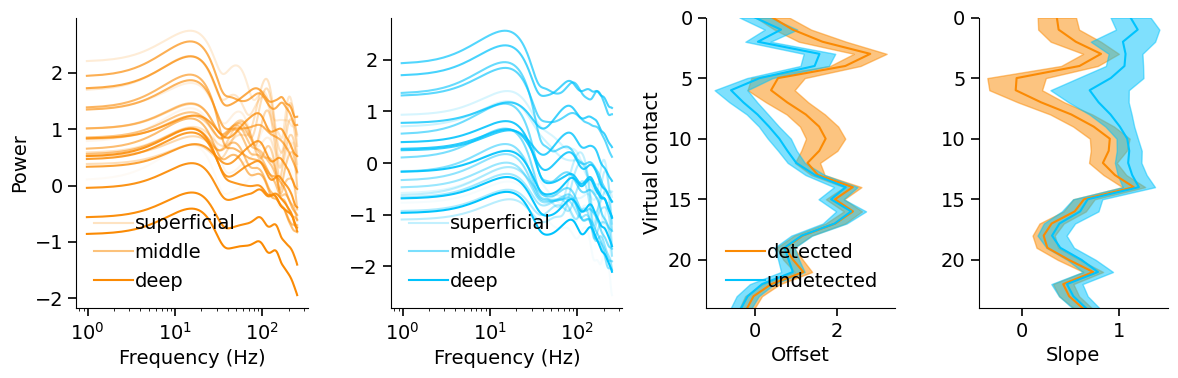

In [19]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(12,4))
undetected_color=np.array([0,76.5,99.2])/100
detected_color=np.array([98.4,54.1,1.2])/100

gs = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

ax1=fig.add_subplot(gs[0])
#m_detected=np.mean(ds_layer_aperiodic,axis=0)
m_detected=np.log10(np.mean(mds_layer_psd,axis=0))
ax1.set_xscale('log')
#ax1.set_yscale('log')
for i in range(n_electrodes):
    label=None
    if i==5:
        label='superficial'
    if i==12:
        label='middle'
    if i==24:
        label='deep'
    ax1.plot(freqs,m_detected[i,:],color=detected_color,alpha=(i+1)/n_electrodes,label=label)
plt.legend()
# ax1.set_xlim([.1,125])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
    
ax2=fig.add_subplot(gs[1])
# m_undetected=np.mean(us_layer_aperiodic,axis=0)
m_undetected=np.log10(np.mean(mus_layer_psd,axis=0))
ax2.set_xscale('log')
# ax2.set_yscale('log')
for i in range(n_electrodes):
    label=None
    if i==5:
        label='superficial'
    if i==12:
        label='middle'
    if i==24:
        label='deep'
    ax2.plot(freqs,m_undetected[i,:],color=undetected_color,alpha=(i+1)/n_electrodes,label=label)
plt.legend()
#ax2.set_xlim([.1,125])
ax2.set_xlabel('Frequency (Hz)')

ax3=fig.add_subplot(gs[2])
m_detected=np.mean(ds_layer_offsets,axis=0)
se_detected=np.std(ds_layer_offsets,axis=0)
ax3.plot(m_detected,np.arange(n_electrodes),
         label='detected',
         color=detected_color)
ax3.fill_betweenx(np.arange(n_electrodes),
                  m_detected-se_detected,
                  m_detected+se_detected,
                  alpha=0.5,
                  color=detected_color)

m_undetected=np.mean(us_layer_offsets,axis=0)
se_undetected=np.std(us_layer_offsets,axis=0)
ax3.plot(m_undetected,
         np.arange(n_electrodes),
         label='undetected',
         color=undetected_color)
ax3.fill_betweenx(np.arange(n_electrodes),
                  m_undetected-se_undetected,
                  m_undetected+se_undetected,
                  alpha=0.5,
                  color=undetected_color)
ax3.set_ylim([n_electrodes-1,0])
ax3.set_ylabel('Virtual contact')
ax3.set_xlabel('Offset')
ax3.legend(loc='lower right')

ax4=fig.add_subplot(gs[3])
m_detected=np.mean(ds_layer_slopes,axis=0)
se_detected=np.std(ds_layer_slopes,axis=0)
ax4.plot(m_detected,np.arange(n_electrodes),
         label='detected',
         color=detected_color)
ax4.fill_betweenx(np.arange(n_electrodes),
                  m_detected-se_detected,
                  m_detected+se_detected,
                  alpha=0.5,
                  color=detected_color)

m_undetected=np.mean(us_layer_slopes,axis=0)
se_undetected=np.std(us_layer_slopes,axis=0)
ax4.plot(m_undetected,
         np.arange(n_electrodes),
         label='undetected',
         color=undetected_color)
ax4.fill_betweenx(np.arange(n_electrodes),
                  m_undetected-se_undetected,
                  m_undetected+se_undetected,
                  alpha=0.5,
                  color=undetected_color)
ax4.set_ylim([n_electrodes-1,0])
ax4.set_xlabel('Slope')

plt.tight_layout()
# plt.savefig('aan-e_i.svg')
# plt.savefig('aan-e_i.png')

In [ ]:
plt.figure()
m_detected=np.log10(np.mean(mds_layer_psd,axis=0))
m_undetected=np.log10(np.mean(mus_layer_psd,axis=0))
im=plt.imshow(m_detected-m_undetected,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Log Power Difference\n(Detected - Undetected)')

In [ ]:
ds_rel_power=np.zeros((n_electrodes,len(freqs)))
for i in range(len(freqs)):
    ds_rel_power[:,i]=m_detected[:,i]/np.max(m_detected[:,i])
im=plt.imshow(ds_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power (Detected)')

In [ ]:
us_rel_power=np.zeros((n_electrodes,len(freqs)))
for i in range(len(freqs)):
    us_rel_power[:,i]=m_undetected[:,i]/np.max(m_undetected[:,i])
im=plt.imshow(us_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power (Undetected)')

In [ ]:
im=plt.imshow(ds_rel_power-us_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power Difference\n(Detected - Undetected)')

**Compute power spectra over whole trial after subtracting out mean response**

In [ ]:
# Compute power spectral density from STFT after subtracting mean - detected stimuli
ds_mean=np.mean(ds_trial_signals,axis=0)
freqs, times, Zxx = scipy.signal.stft(ds_trial_signals-ds_mean, fs=srate, window='hann', nperseg=winsize,
                                      noverlap=overlap, nfft=int(winsize * 20), detrend='constant',
                                      return_onesided=True, boundary='zeros', padded=True, axis=-1)
ds_layer_resid_psd = np.abs(Zxx) ** 2
f_idx=(freqs>=freq_lims[0]) & (freqs<freq_lims[1])
freqs=freqs[f_idx]
ds_layer_resid_psd=ds_layer_resid_psd[:,:,f_idx,:]
mds_layer_resid_psd=np.mean(ds_layer_resid_psd,axis=-1)


# Compute power spectral density from STFT after subtracting mean - undetected stimuli
us_mean=np.mean(us_trial_signals,axis=0)
freqs, times, Zxx = scipy.signal.stft(us_trial_signals-us_mean, fs=srate, window='hann', nperseg=winsize,
                                      noverlap=overlap, nfft=int(winsize * 20), detrend='constant',
                                      return_onesided=True, boundary='zeros', padded=True, axis=-1)
us_layer_resid_psd = np.abs(Zxx) ** 2
f_idx=(freqs>=freq_lims[0]) & (freqs<freq_lims[1])
freqs=freqs[f_idx]
us_layer_resid_psd=us_layer_resid_psd[:,:,f_idx,:]
mus_layer_resid_psd=np.mean(us_layer_resid_psd,axis=-1)

**Parameterize power spectra**

In [ ]:
ds_layer_resid_offsets=np.zeros((n_trials,n_electrodes))
ds_layer_resid_slopes=np.zeros((n_trials,n_electrodes))
ds_layer_resid_aperiodic=np.zeros((n_trials,n_electrodes,len(freqs)))
for t in range(mds_layer_resid_psd.shape[0]):
    trial_psd=mds_layer_resid_psd[t,:,:]
    
    fg = FOOOFGroup()
    fg.fit(freqs,trial_psd, freq_lims)
    for i in range(trial_psd.shape[0]):
        ds_layer_resid_offsets[t,i]=fg[i].aperiodic_params[0]
        ds_layer_resid_slopes[t,i]=fg[i].aperiodic_params[1]
        ds_layer_resid_aperiodic[t,i,:]=gen_aperiodic(freqs,fg[i].aperiodic_params)

us_layer_resid_offsets=np.zeros((n_trials,n_electrodes))
us_layer_resid_slopes=np.zeros((n_trials,n_electrodes))
us_layer_resid_aperiodic=np.zeros((n_trials,n_electrodes,len(freqs)))
for t in range(mus_layer_resid_psd.shape[0]):
    trial_psd=mus_layer_resid_psd[t,:,:]
    
    fg = FOOOFGroup()
    fg.fit(freqs,trial_psd, freq_lims)
    for i in range(trial_psd.shape[0]):
        us_layer_resid_offsets[t,i]=fg[i].aperiodic_params[0]
        us_layer_resid_slopes[t,i]=fg[i].aperiodic_params[1]
        us_layer_resid_aperiodic[t,i,:]=gen_aperiodic(freqs,fg[i].aperiodic_params)

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

**Plot spectra and parameters**

In [ ]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(12,4))
undetected_color=np.array([0,76.5,99.2])/100
detected_color=np.array([98.4,54.1,1.2])/100

gs = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

ax1=fig.add_subplot(gs[0])
#m_detected=np.mean(ds_layer_aperiodic,axis=0)
m_detected=np.log10(np.mean(mds_layer_resid_psd,axis=0))
ax1.set_xscale('log')
# ax1.set_yscale('log')
for i in range(n_electrodes):
    label=None
    if i==5:
        label='superficial'
    if i==12:
        label='middle'
    if i==24:
        label='deep'
    ax1.plot(freqs,m_detected[i,:],color=detected_color,alpha=(i+1)/n_electrodes,label=label)
plt.legend()
# ax1.set_xlim([.1,125])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
    
ax2=fig.add_subplot(gs[1])
# m_undetected=np.mean(us_layer_aperiodic,axis=0)
m_undetected=np.log10(np.mean(mus_layer_resid_psd,axis=0))
ax2.set_xscale('log')
# ax2.set_yscale('log')
for i in range(n_electrodes):
    label=None
    if i==5:
        label='superficial'
    if i==12:
        label='middle'
    if i==24:
        label='deep'
    ax2.plot(freqs,m_undetected[i,:],color=undetected_color,alpha=(i+1)/n_electrodes,label=label)
plt.legend()
#ax2.set_xlim([.1,125])
ax2.set_xlabel('Frequency (Hz)')

ax3=fig.add_subplot(gs[2])
m_detected=np.mean(ds_layer_resid_offsets,axis=0)
se_detected=np.std(ds_layer_resid_offsets,axis=0)
ax3.plot(m_detected,np.arange(n_electrodes),
         label='detected',
         color=detected_color)
ax3.fill_betweenx(np.arange(n_electrodes),
                  m_detected-se_detected,
                  m_detected+se_detected,
                  alpha=0.5,
                  color=detected_color)

m_undetected=np.mean(us_layer_resid_offsets,axis=0)
se_undetected=np.std(us_layer_resid_offsets,axis=0)
ax3.plot(m_undetected,
         np.arange(n_electrodes),
         label='undetected',
         color=undetected_color)
ax3.fill_betweenx(np.arange(n_electrodes),
                  m_undetected-se_undetected,
                  m_undetected+se_undetected,
                  alpha=0.5,
                  color=undetected_color)
ax3.set_ylim([n_electrodes-1,0])
ax3.set_ylabel('Virtual contact')
ax3.set_xlabel('Offset')
ax3.legend(loc='lower right')

ax4=fig.add_subplot(gs[3])
m_detected=np.mean(ds_layer_resid_slopes,axis=0)
se_detected=np.std(ds_layer_resid_slopes,axis=0)
ax4.plot(m_detected,np.arange(n_electrodes),
         label='detected',
         color=detected_color)
ax4.fill_betweenx(np.arange(n_electrodes),
                  m_detected-se_detected,
                  m_detected+se_detected,
                  alpha=0.5,
                  color=detected_color)

m_undetected=np.mean(us_layer_resid_slopes,axis=0)
se_undetected=np.std(us_layer_resid_slopes,axis=0)
ax4.plot(m_undetected,
         np.arange(n_electrodes),
         label='undetected',
         color=undetected_color)
ax4.fill_betweenx(np.arange(n_electrodes),
                  m_undetected-se_undetected,
                  m_undetected+se_undetected,
                  alpha=0.5,
                  color=undetected_color)
ax4.set_ylim([n_electrodes-1,0])
ax4.set_xlabel('Slope')

plt.tight_layout()
# plt.savefig('aan-e_i.svg')
# plt.savefig('aan-e_i.png')

In [ ]:
plt.figure()
m_detected=np.log10(np.mean(mds_layer_resid_psd,axis=0))
m_undetected=np.log10(np.mean(mus_layer_resid_psd,axis=0))
im=plt.imshow(m_detected-m_undetected,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Log Power Difference\n(Detected - Undetected)')

In [ ]:
ds_rel_power=np.zeros((n_electrodes,len(freqs)))
for i in range(len(freqs)):
    ds_rel_power[:,i]=m_detected[:,i]/np.max(m_detected[:,i])
im=plt.imshow(ds_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power (Detected)')

In [ ]:
us_rel_power=np.zeros((n_electrodes,len(freqs)))
for i in range(len(freqs)):
    us_rel_power[:,i]=m_undetected[:,i]/np.max(m_undetected[:,i])
im=plt.imshow(us_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power (Undetected)')

In [ ]:
im=plt.imshow(ds_rel_power-us_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power Difference\n(Detected - Undetected)')

**Compute power spectra over whole trial after regressing out mean response**

In [ ]:
# Compute power spectral density from STFT after regressing out mean - detected stimuli
ds_mean=np.mean(ds_trial_signals,axis=0)
ds_trial_resids=np.zeros(ds_trial_signals.shape)
for t_idx in range(n_trials):
    for e_idx in range(n_electrodes):
        # Regress out ERF
        slope, intercept, r, p, se = linregress(ds_mean[e_idx,:], ds_trial_signals[t_idx, e_idx, :])
        ds_trial_resids[t_idx,e_idx,:] = ds_trial_signals[t_idx, e_idx, :] - (intercept + slope * ds_mean[e_idx,:])
freqs, times, Zxx = scipy.signal.stft(ds_trial_resids, fs=srate, window='hann', nperseg=winsize,
                                      noverlap=overlap, nfft=int(winsize * 20), detrend='constant',
                                      return_onesided=True, boundary='zeros', padded=True, axis=-1)
ds_layer_resid_psd = np.abs(Zxx) ** 2
f_idx=(freqs>=freq_lims[0]) & (freqs<freq_lims[1])
freqs=freqs[f_idx]
ds_layer_resid_psd=ds_layer_resid_psd[:,:,f_idx,:]
mds_layer_resid_psd=np.mean(ds_layer_resid_psd,axis=-1)

# Compute power spectral density from STFT after regressing out mean - undetected stimuli
us_mean=np.mean(us_trial_signals,axis=0)
us_trial_resids=np.zeros(us_trial_signals.shape)
for t_idx in range(n_trials):
    for e_idx in range(n_electrodes):
        # Regress out ERF
        slope, intercept, r, p, se = linregress(us_mean[e_idx,:], us_trial_signals[t_idx, e_idx, :])
        us_trial_resids[t_idx,e_idx,:] = us_trial_signals[t_idx, e_idx, :] - (intercept + slope * us_mean[e_idx,:])
freqs, times, Zxx = scipy.signal.stft(us_trial_resids, fs=srate, window='hann', nperseg=winsize,
                                      noverlap=overlap, nfft=int(winsize * 20), detrend='constant',
                                      return_onesided=True, boundary='zeros', padded=True, axis=-1)
us_layer_resid_psd = np.abs(Zxx) ** 2
f_idx=(freqs>=freq_lims[0]) & (freqs<freq_lims[1])
freqs=freqs[f_idx]
us_layer_resid_psd=us_layer_resid_psd[:,:,f_idx,:]
mus_layer_resid_psd=np.mean(us_layer_resid_psd,axis=-1)

**Parameterize power spectra**

In [ ]:
ds_layer_resid_offsets=np.zeros((n_trials,n_electrodes))
ds_layer_resid_slopes=np.zeros((n_trials,n_electrodes))
ds_layer_resid_aperiodic=np.zeros((n_trials,n_electrodes,len(freqs)))
for t in range(mds_layer_resid_psd.shape[0]):
    trial_psd=mds_layer_resid_psd[t,:,:]
    
    fg = FOOOFGroup()
    fg.fit(freqs,trial_psd, freq_lims)
    for i in range(trial_psd.shape[0]):
        ds_layer_resid_offsets[t,i]=fg[i].aperiodic_params[0]
        ds_layer_resid_slopes[t,i]=fg[i].aperiodic_params[1]
        ds_layer_resid_aperiodic[t,i,:]=gen_aperiodic(freqs,fg[i].aperiodic_params)

us_layer_resid_offsets=np.zeros((n_trials,n_electrodes))
us_layer_resid_slopes=np.zeros((n_trials,n_electrodes))
us_layer_resid_aperiodic=np.zeros((n_trials,n_electrodes,len(freqs)))
for t in range(mus_layer_resid_psd.shape[0]):
    trial_psd=mus_layer_resid_psd[t,:,:]
    
    fg = FOOOFGroup()
    fg.fit(freqs,trial_psd, freq_lims)
    for i in range(trial_psd.shape[0]):
        us_layer_resid_offsets[t,i]=fg[i].aperiodic_params[0]
        us_layer_resid_slopes[t,i]=fg[i].aperiodic_params[1]
        us_layer_resid_aperiodic[t,i,:]=gen_aperiodic(freqs,fg[i].aperiodic_params)

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 25 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lo

**Plot spectra and parameters**

In [ ]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(12,4))
undetected_color=np.array([0,76.5,99.2])/100
detected_color=np.array([98.4,54.1,1.2])/100

gs = GridSpec(1, 4, width_ratios=[.275, .275, .225, .225])

ax1=fig.add_subplot(gs[0])
#m_detected=np.mean(ds_layer_aperiodic,axis=0)
m_detected=np.log10(np.mean(mds_layer_resid_psd,axis=0))
ax1.set_xscale('log')
# ax1.set_yscale('log')
for i in range(n_electrodes):
    label=None
    if i==5:
        label='superficial'
    if i==12:
        label='middle'
    if i==24:
        label='deep'
    ax1.plot(freqs,m_detected[i,:],color=detected_color,alpha=(i+1)/n_electrodes,label=label)
plt.legend()
# ax1.set_xlim([.1,125])
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power')
    
ax2=fig.add_subplot(gs[1])
# m_undetected=np.mean(us_layer_aperiodic,axis=0)
m_undetected=np.log10(np.mean(mus_layer_resid_psd,axis=0))
ax2.set_xscale('log')
# ax2.set_yscale('log')
for i in range(n_electrodes):
    label=None
    if i==5:
        label='superficial'
    if i==12:
        label='middle'
    if i==24:
        label='deep'
    ax2.plot(freqs,m_undetected[i,:],color=undetected_color,alpha=(i+1)/n_electrodes,label=label)
plt.legend()
#ax2.set_xlim([.1,125])
ax2.set_xlabel('Frequency (Hz)')

ax3=fig.add_subplot(gs[2])
m_detected=np.mean(ds_layer_resid_offsets,axis=0)
se_detected=np.std(ds_layer_resid_offsets,axis=0)
ax3.plot(m_detected,np.arange(n_electrodes),
         label='detected',
         color=detected_color)
ax3.fill_betweenx(np.arange(n_electrodes),
                  m_detected-se_detected,
                  m_detected+se_detected,
                  alpha=0.5,
                  color=detected_color)

m_undetected=np.mean(us_layer_resid_offsets,axis=0)
se_undetected=np.std(us_layer_resid_offsets,axis=0)
ax3.plot(m_undetected,
         np.arange(n_electrodes),
         label='undetected',
         color=undetected_color)
ax3.fill_betweenx(np.arange(n_electrodes),
                  m_undetected-se_undetected,
                  m_undetected+se_undetected,
                  alpha=0.5,
                  color=undetected_color)
ax3.set_ylim([n_electrodes-1,0])
ax3.set_ylabel('Virtual contact')
ax3.set_xlabel('Offset')
ax3.legend(loc='lower right')

ax4=fig.add_subplot(gs[3])
m_detected=np.mean(ds_layer_resid_slopes,axis=0)
se_detected=np.std(ds_layer_resid_slopes,axis=0)
ax4.plot(m_detected,np.arange(n_electrodes),
         label='detected',
         color=detected_color)
ax4.fill_betweenx(np.arange(n_electrodes),
                  m_detected-se_detected,
                  m_detected+se_detected,
                  alpha=0.5,
                  color=detected_color)

m_undetected=np.mean(us_layer_resid_slopes,axis=0)
se_undetected=np.std(us_layer_resid_slopes,axis=0)
ax4.plot(m_undetected,
         np.arange(n_electrodes),
         label='undetected',
         color=undetected_color)
ax4.fill_betweenx(np.arange(n_electrodes),
                  m_undetected-se_undetected,
                  m_undetected+se_undetected,
                  alpha=0.5,
                  color=undetected_color)
ax4.set_ylim([n_electrodes-1,0])
ax4.set_xlabel('Slope')

plt.tight_layout()
# plt.savefig('aan-e_i.svg')
# plt.savefig('aan-e_i.png')

In [ ]:
plt.figure()
m_detected=np.log10(np.mean(mds_layer_resid_psd,axis=0))
m_undetected=np.log10(np.mean(mus_layer_resid_psd,axis=0))
im=plt.imshow(m_detected-m_undetected,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Log Power Difference\n(Detected - Undetected)')

In [ ]:
ds_rel_power=np.zeros((n_electrodes,len(freqs)))
for i in range(len(freqs)):
    ds_rel_power[:,i]=m_detected[:,i]/np.max(m_detected[:,i])
im=plt.imshow(ds_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power (Detected)')

In [ ]:
us_rel_power=np.zeros((n_electrodes,len(freqs)))
for i in range(len(freqs)):
    us_rel_power[:,i]=m_undetected[:,i]/np.max(m_undetected[:,i])
im=plt.imshow(us_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power (Undetected)')

In [ ]:
im=plt.imshow(ds_rel_power-us_rel_power,aspect='auto',extent=(freqs[0], freqs[-1], n_electrodes-1, 0))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Virtual contact')
cbar=plt.colorbar(im)
cbar.set_label('Relative Power Difference\n(Detected - Undetected)')